In [1]:
import pandas as pd
from collections import defaultdict
import dvc.api
from tqdm import tqdm
import numpy as np

In [2]:
df_original = pd.read_csv(dvc.api.get_url('modelling/notebooks/query_attr_extract_appen_label/appen_query_attribution_batch1.csv', 
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'))

In [5]:
df = pd.read_csv('appen/output_batch_correct_v2/query_attribution_02.03.23.csv')

In [6]:
df_original.head(2)

,query,sample_method,label_ordering,top_query_classification_taxonomy
0,dog cat eater,uniform,0,Home & Garden > Pet Products > Cat Supplies > ...
1,fish holder tool,head,18,Sports > Fishing > Fishing Tools


In [7]:
df_original['label_ordering'].isna().mean()

0.0

In [9]:
df

,Label_Ordering,Sample_Method,L2_Category,Query_Category,Rater_Answer,Query
0,18,head,Sports > Fishing,Sports > Fishing > Fishing Tools,Sports > Fishing > Fishing Tools > fish holder,fish holder tool
1,225,head,"Home & Garden > Arts, Crafts & Sewing","Home & Garden > Arts, Crafts & Sewing > Button...","Home & Garden > Arts, Crafts & Sewing > Potter...",molde gesso 3d silicone
2,288,head,Jewelry & Accessories > Fine Jewelry,Jewelry & Accessories > Fine Jewelry > Necklaces,Jewelry & Accessories > Fine Jewelry > Necklac...,medayas de oro
3,293,head,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,case para huawei y9 prime 2019
4,314,uniform,"Home & Garden > Arts, Crafts & Sewing","Home & Garden > Arts, Crafts & Sewing > Appare...","Home & Garden > Arts, Crafts & Sewing > Appare...",lace dots meter
...,...,...,...,...,...,...
74978,1495346,head,"Home & Garden > Kitchen,Dining & Bar","Home & Garden > Kitchen,Dining & Bar > Teaware...",NaN,tea cup sets of 12
74979,1495360,head,Sports > Camping & Hiking,Sports > Camping & Hiking > Camping Furnishing...,Sports > Camping & Hiking > Camping Furnishing...,portable camping chair
74980,1495367,head,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,Cellphones & Telecommunications > Mobile Phone...,western phone cases
74981,1495381,head,Home & Garden > Household Merchandise,Home & Garden > Household Merchandise > Lighte...,Home & Garden > Household Merchandise > Lighte...,máquina de fazer cigarros


In [10]:
df = df.merge(df_original[['label_ordering', 'query', 'top_query_classification_taxonomy']].rename(columns={
    'query': 'query_original',
    'label_ordering': 'Label_Ordering'
}), on='Label_Ordering', how='inner')

In [11]:
(df['query_original'] != df['Query']).mean()

0.00018670898737047065

In [14]:
df[df['query_original'] != df['Query']].sample(2).to_dict('records')

[{'Label_Ordering': 935277,
  'Sample_Method': 'uniform',
  'L2_Category': 'Home & Garden > Home Decor',
  'Query_Category': 'Home & Garden > Home Decor > Ornaments > Shells & Starfish',
  'Rater_Answer': 'Home & Garden > Home Decor > Ornaments > Shells & Starfish',
  'Query': 'the shells with the pink balls in',
  'query_original': 'the shells with the pink balls in￼',
  'top_query_classification_taxonomy': 'Home & Garden > Home Decor > Ornaments > Shells & Starfish'},
 {'Label_Ordering': 1162990,
  'Sample_Method': 'uniform',
  'L2_Category': 'Home & Garden > Household Merchandise',
  'Query_Category': 'Home & Garden > Household Merchandise > Lighters & Smoking Accessories > Shisha Pipes & Accessories',
  'Rater_Answer': 'Home & Garden > Household Merchandise > Lighters & Smoking Accessories > Shisha Pipes & Accessories',
  'Query': 'bong small cheap',
  'query_original': 'bong small cheap￼',
  'top_query_classification_taxonomy': 'Home & Garden > Household Merchandise > Lighters & S

In [16]:
(df['Query_Category'] != df['top_query_classification_taxonomy']).mean()

0.0

In [26]:
df = pd.read_csv('appen/output_batch_correct_v2/query_attribution_02.03.23.csv')
errors = []
correct = []
empty = []
for i in tqdm(df[['Query', 'Rater_Answer', 'Query_Category']].to_dict('records')):
    res = [] if ((not isinstance(i['Rater_Answer'], str)) and (np.isnan(i['Rater_Answer']))) else i['Rater_Answer'].split('\n')
    if len(res) == 0:
        empty.append(i)
    is_correct = True
    for j in res:
        if not j.startswith(i['Query_Category']):
            errors.append(i)
            is_correct = False
            break
    if is_correct:
        correct.append(i)
len(correct) / len(df), len(errors) / len(df), len(empty) / len(df)

100%|██████████| 74983/74983 [00:00<00:00, 486114.50it/s]


(0.7627995679020578, 0.2372004320979422, 0.1449128469119667)

<AxesSubplot: ylabel='Query_Category_L2'>

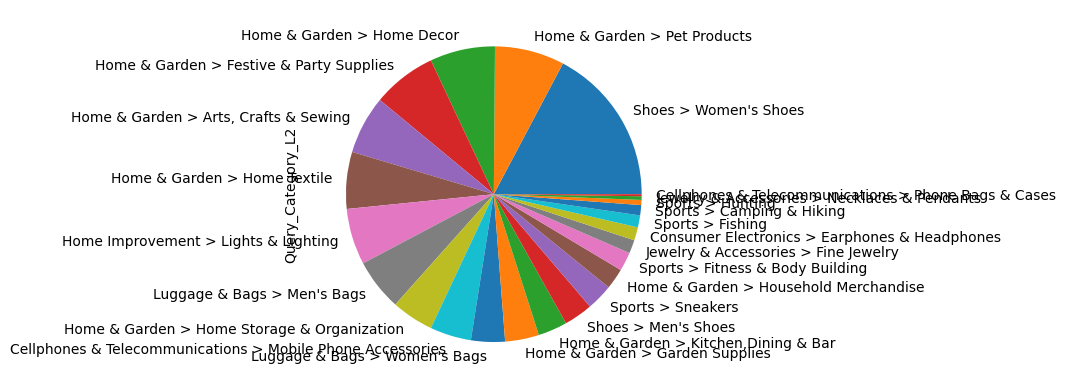

In [27]:
df_errors = pd.DataFrame(errors)
df_errors['Query_Category_L2'] = df_errors['Query_Category'].apply(lambda x: ' > '.join(x.split(' > ')[:2]))
df_errors['Query_Category_L2'].value_counts().plot.pie()

In [19]:
correct[:5]

[{'Query': 'fish holder tool',
  'query_original': 'fish holder tool',
  'Rater_Answer': 'Sports > Fishing > Fishing Tools > fish holder',
  'Query_Category': 'Sports > Fishing > Fishing Tools'},
 {'Query': 'medayas de oro',
  'query_original': 'medayas de oro',
  'Rater_Answer': 'Jewelry & Accessories > Fine Jewelry > Necklaces > Materials > Gold\nJewelry & Accessories > Fine Jewelry > Necklaces > Occasion & Lifestyle > Honor award',
  'Query_Category': 'Jewelry & Accessories > Fine Jewelry > Necklaces'},
 {'Query': 'case para huawei y9 prime 2019',
  'query_original': 'case para huawei y9 prime 2019',
  'Rater_Answer': 'Cellphones & Telecommunications > Mobile Phone Accessories > Phone Case & Covers > Brand > huawei y9 prime 2019',
  'Query_Category': 'Cellphones & Telecommunications > Mobile Phone Accessories > Phone Case & Covers'},
 {'Query': 'lace dots meter',
  'query_original': 'lace dots meter',
  'Rater_Answer': 'Home & Garden > Arts, Crafts & Sewing > Apparel Sewing & Fabric

In [21]:
# query errors
errors[:5]

[{'Query': 'molde gesso 3d silicone',
  'query_original': 'molde gesso 3d silicone',
  'Rater_Answer': 'Home & Garden > Arts, Crafts & Sewing > Pottery & Ceramics > Clay Molds > Materials > Silicone\nHome & Garden > Arts, Crafts & Sewing > Pottery & Ceramics > Clay Molds > Pattern > 3D',
  'Query_Category': 'Home & Garden > Arts, Crafts & Sewing > Button & Badge Making > Maker Molds'},
 {'Query': 'gucci pouch mens',
  'query_original': 'gucci pouch mens',
  'Rater_Answer': "Luggage & Bags > Women's Bags > Waist Packs > Department > Men > gucci",
  'Query_Category': "Luggage & Bags > Men's Bags > Waist Packs"},
 {'Query': 'housse de couette 90x190',
  'query_original': 'housse de couette 90x190',
  'Rater_Answer': 'Home & Garden > Home Textile > Duvet Cover Sets > Size > 90x190',
  'Query_Category': 'Home & Garden > Home Textile > Bedding > Duvet Covers'},
 {'Query': 'caixa porta joias',
  'query_original': 'caixa porta joias',
  'Rater_Answer': 'Home & Garden > Home Storage & Organizat